In [ ]:
!pip uninstall -y fbprophet
!pip uninstall -y pystan
!pip install fbprophet
!pip install pystan==2.19.1.1

Found existing installation: pystan 2.19.1.1
Uninstalling pystan-2.19.1.1:
  Successfully uninstalled pystan-2.19.1.1
  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.9.1-py3-none-any.whl (13 kB)
  error: subprocess-exited-with-error
  
  √ó python setup.py bdist_wheel did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
Failed to build fbprophet
ERROR: Could not build wheels for fbprophet, which is required to install pyproject.toml-based projects
  Using cached pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl


In [ ]:
# Bibliotecas b√°sicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacion√°rios
from statsmodels.tsa.stattools import acf, pacf         #correla√ß√£o
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposi√ß√£o sazonal usando m√©dias m√≥veis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

#Upload do DataFrame

In [ ]:
import yfinance as yf

# Especifique o s√≠mbolo do Brent Crude Oil Last Day Financ (BZ=F) e o intervalo de datas desejado
symbol = 'BZ=F'

start_date = '1987-05-20' #data mais antiga do valor do IPEA (url providenciada no challenge)
end_date = '2024-05-20' #data escolhida para o final dos dados

# Use a fun√ß√£o download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...               ...        ...        ...        ...        ...     ...
2024-05-08  83.040001  83.820000  81.720001  83.580002  83.580002   35419
2024-05-09  83.779999  84.330002  83.459999  83.879997  83.879997   25231
2024-05-10  84.209999  84.519997  82.709999  82.790001  82.790001   25062
2024-05-13  82.699997  83.830002  82.260002  83.360001  83.360001   29242
2024-05-14  82.769997  82.910004  82.650002  82.849998  82.849998     401

[4169 rows x 6 columns]

In [ ]:
df_copy = df

In [ ]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a convers√£o da data para formato datetime
df.head()

Date       Open       High        Low      Close  Adj Close  Volume
0 2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
1 2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2 2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
3 2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
4 2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387

In [ ]:
df.shape #analisando linhas e colunas

(4169, 7)

In [ ]:
df_brent = df # criando c√≥pia do dataset

### Visualizando os valores de fechamento

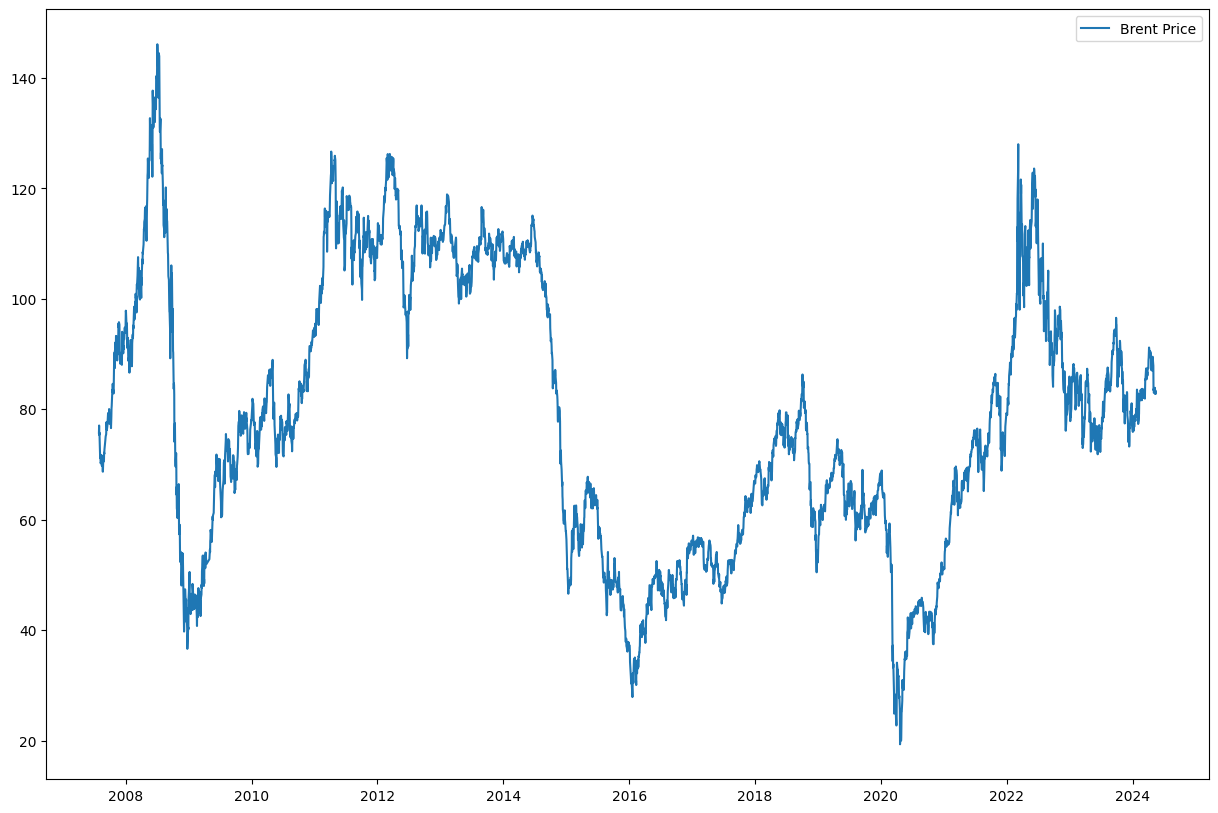

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Close'], label='Brent Price')

plt.legend(loc='best')
plt.show()

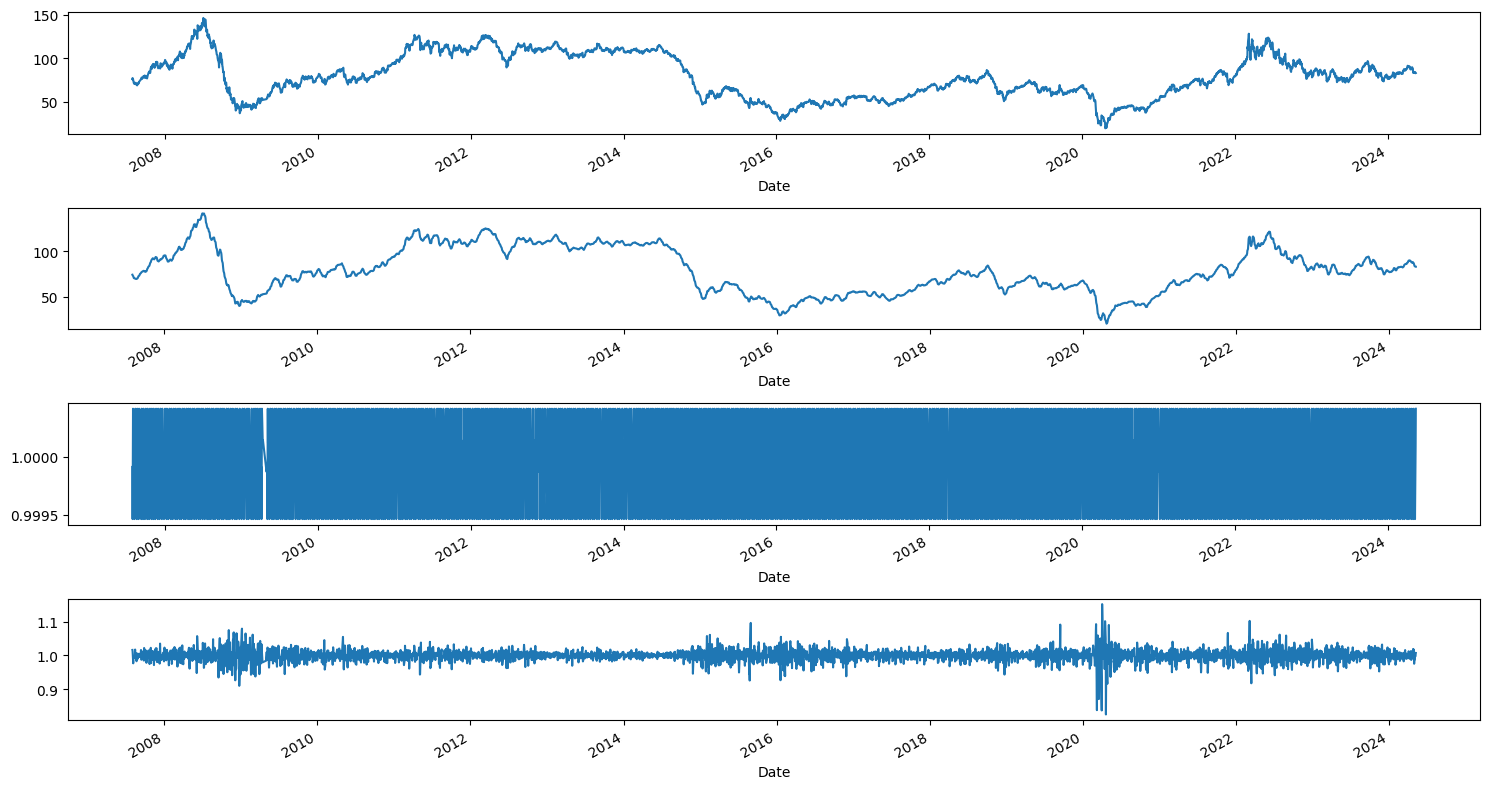

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # c√≥pia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecess√°rias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como √≠ndice

################################## Notas da an√°lise de decomposi√ß√£o da s√©rie ########################################

# model='additive': Este par√¢metro especifica o tipo de modelo utilizado na decomposi√ß√£o.

# Os dois tipos principais s√£o:

# "additive" (modelo apropriado quando a magnitude da sazonalidade n√£o varia com a tend√™ncia)
# "multiplicative" (modelo √© mais apropriado quando a magnitude da sazonalidade varia com a tend√™ncia).

# period: Este √© o per√≠odo da sazonalidade. Ele especifica o n√∫mero de observa√ß√µes em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=7) #decopondo a s√©rie temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

In [ ]:
df_limpo

Close
Date                 
2007-07-30  75.739998
2007-07-31  77.050003
2007-08-01  75.349998
2007-08-02  75.760002
2007-08-03  74.750000
...               ...
2024-05-08  83.580002
2024-05-09  83.879997
2024-05-10  82.790001
2024-05-13  83.360001
2024-05-14  82.849998

[4169 rows x 1 columns]

In [ ]:
#Filtrando os dados
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)

In [ ]:
df['MA_window_10'] = df['Close'].rolling(10).mean().shift() #m√©dia m√≥vel em 10 dias
df['MA_window_20'] = df['Close'].rolling(20).mean().shift() #m√©dia m√≥vel em 20 dias

#Rolling para deslocamento. Este par√¢metro especifica o n√∫mero de observa√ß√µes usadas para calcular a estat√≠stica
#shift √© utilizado para deslocar o √≠ndice de DataFrame por um n√∫mero especificado de per√≠odos com uma freq√º√™ncia de tempo opcional

In [ ]:
df.head(20)

Close  MA_window_10  MA_window_20
Date                                             
2007-07-30  75.739998           NaN           NaN
2007-07-31  77.050003           NaN           NaN
2007-08-01  75.349998           NaN           NaN
2007-08-02  75.760002           NaN           NaN
2007-08-03  74.750000           NaN           NaN
2007-08-06  71.169998           NaN           NaN
2007-08-07  71.800003           NaN           NaN
2007-08-08  70.989998           NaN           NaN
2007-08-09  70.209999           NaN           NaN
2007-08-10  70.389999           NaN           NaN
2007-08-13  70.230003        73.321           NaN
2007-08-14  70.510002        72.770           NaN
2007-08-15  71.639999        72.116           NaN
2007-08-16  69.769997        71.745           NaN
2007-08-17  70.440002        71.146           NaN
2007-08-20  69.849998        70.715           NaN
2007-08-21  68.690002        70.583           NaN
2007-08-22  68.699997        70.272           NaN
2007-08-23  69.860001        70.043           NaN
2007-08-24  70.620003        70.008           NaN

### Visualizando o Resultado

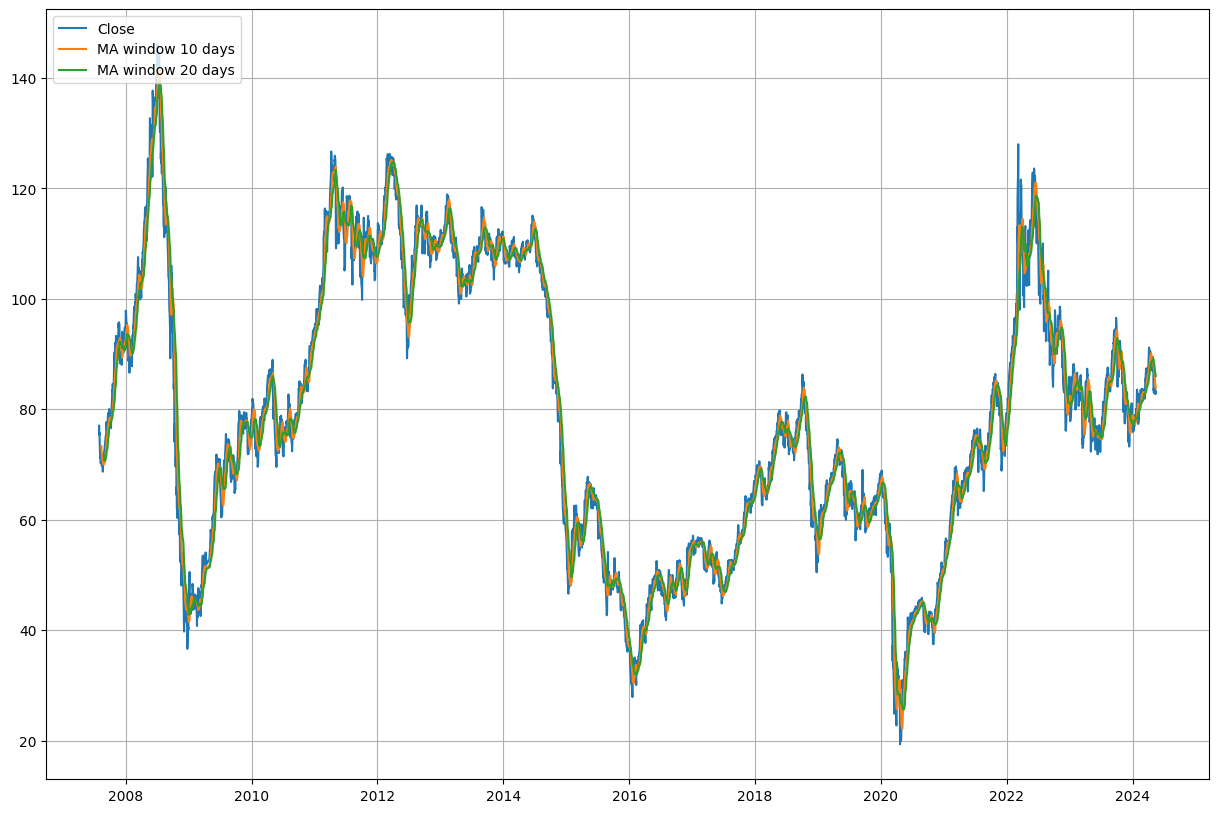

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: √∫ltimos 300 dias

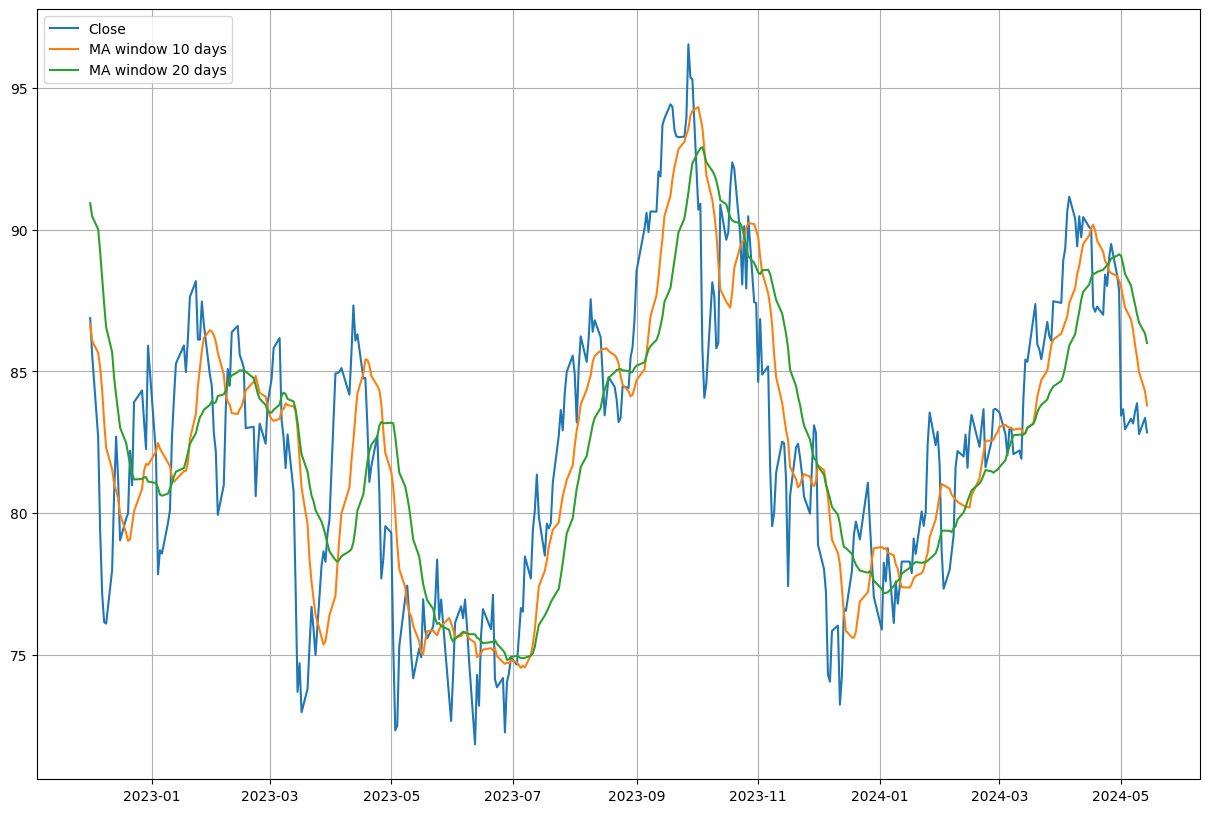

In [ ]:
limit = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na m√©dia m√≥vel aritm√©tica

In [ ]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Itera√ß√£o sobre a s√©rie temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Itera√ß√£o para calcular a m√©dia m√≥vel ponderada
    for i in range(0, forward_days):
        # Verifica se o √≠ndice atual est√° dentro dos limites da s√©rie temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a m√©dia m√≥vel ('window_close')
        # 2. Uma janela para a s√©rie temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a m√©dia m√≥vel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a m√©dia m√≥vel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


Plotando os dados

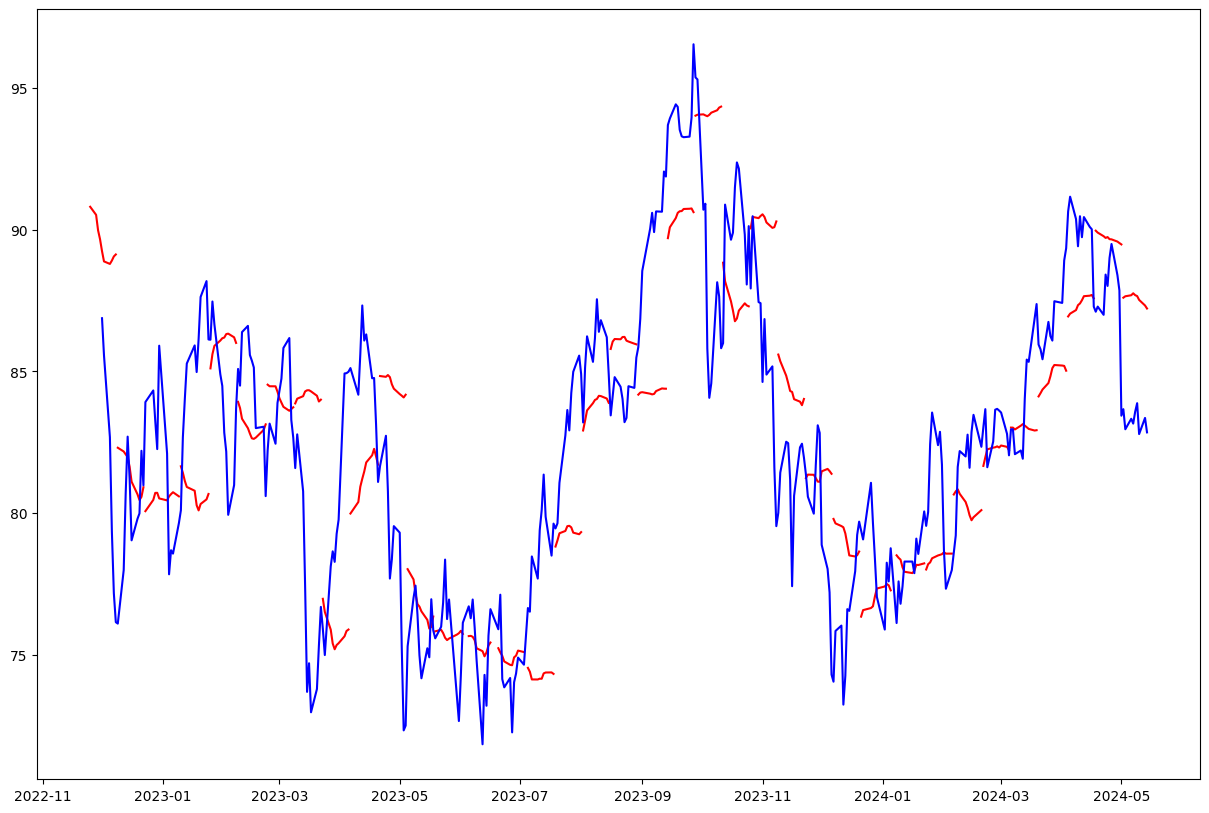

In [ ]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Testando ARIMA

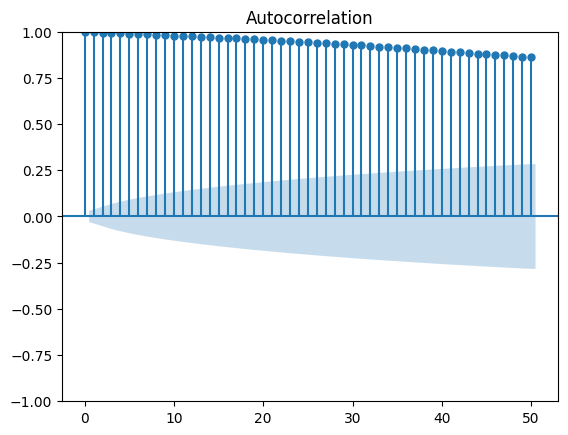

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

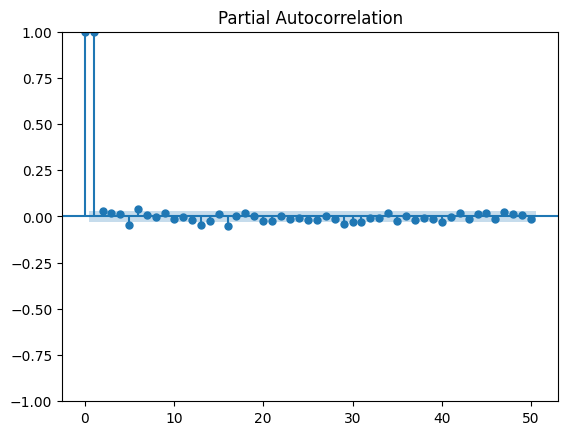

In [ ]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

In [ ]:
#Analisando M√©dia M√≥vel e Desvio Padr√£o

rolmean = df_limpo.rolling(window=12).mean() #m√©dia m√≥vel em 12 meses (dando a m√©dia m√≥vel no n√≠vel anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padr√£o em 12 meses
print(rolmean,rolstd)

                Close
Date                 
2007-07-30        NaN
2007-07-31        NaN
2007-08-01        NaN
2007-08-02        NaN
2007-08-03        NaN
...               ...
2024-05-08  85.945834
2024-05-09  85.567500
2024-05-10  85.131667
2024-05-13  84.660834
2024-05-14  84.106667

[4169 rows x 1 columns]                Close
Date                
2007-07-30       NaN
2007-07-31       NaN
2007-08-01       NaN
2007-08-02       NaN
2007-08-03       NaN
...              ...
2024-05-08  2.742034
2024-05-09  2.682177
2024-05-10  2.672336
2024-05-13  2.411945
2024-05-14  1.910942

[4169 rows x 1 columns]


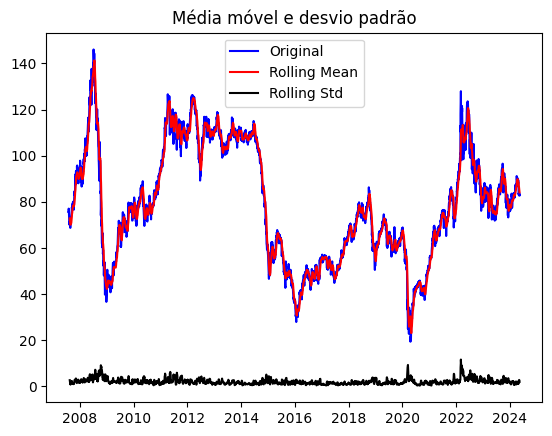

In [ ]:
#Plotando a m√©dia m√≥vel
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('M√©dia m√≥vel e desvio padr√£o')
plt.show(block=False)

# Verificar estacionariedade da s√©rie temporal üìà

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estat√≠stico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Cr√≠ticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.2962474230714363
p-value: 0.17318110879217768
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estat√≠stico: -2.2962474230714363
Valor-p: 0.17318110879217768
Valores Cr√≠ticos:
   1%: -3.431925571033693
   5%: -2.862236200776663
   10%: -2.5671405938787677


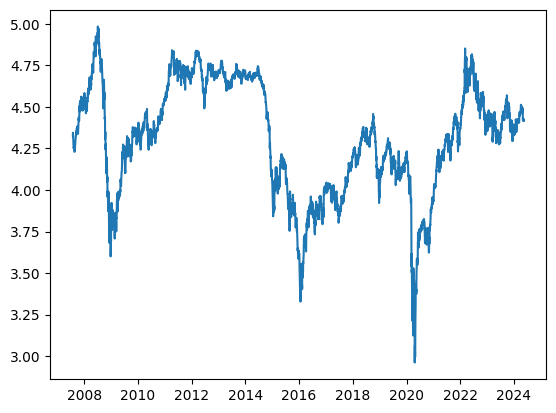

In [ ]:
#Estimating trend
indexedDataset_logScale = np.log(df_limpo) #Transforma√ß√£o logar√≠tma
plt.plot(indexedDataset_logScale)

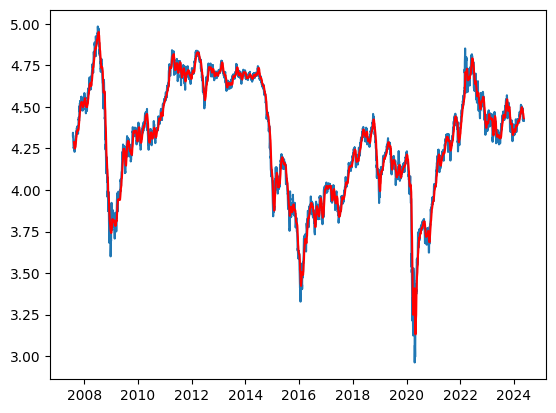

In [ ]:
# Calculando a m√©dia m√≥vel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

Close
Date                
2007-08-14 -0.031761
2007-08-15 -0.011225
2007-08-16 -0.029403
2007-08-17 -0.014231
2007-08-20 -0.015874
2007-08-21 -0.025575
2007-08-22 -0.022486
2007-08-23 -0.003459
2007-08-24  0.007797
2007-08-27  0.011585

In [ ]:
# Fun√ß√£o para testar a estacionariedade da s√©rie transformada

def test_stationarity(timeseries):

    #Determinar estat√≠sticas cont√≠nuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estat√≠sticas cont√≠nuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey‚ÄìFuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


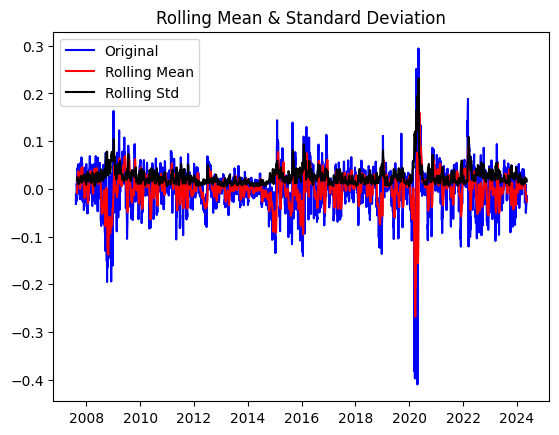

Results of Dickey Fuller Test:
Test Statistic                -1.004236e+01
p-value                        1.484714e-17
#Lags Used                     2.000000e+01
Number of Observations Used    4.137000e+03
Critical Value (1%)           -3.431932e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

### 2¬∫ teste : Decaimento exponencial.



---



**Objetivo:** Remover a tend√™ncia de uma s√©rie temporal. A ideia b√°sica √© aplicar uma m√©dia exponencial ponderada aos dados, atribuindo mais peso √†s observa√ß√µes mais recentes e menos peso √†s observa√ß√µes mais antigas.


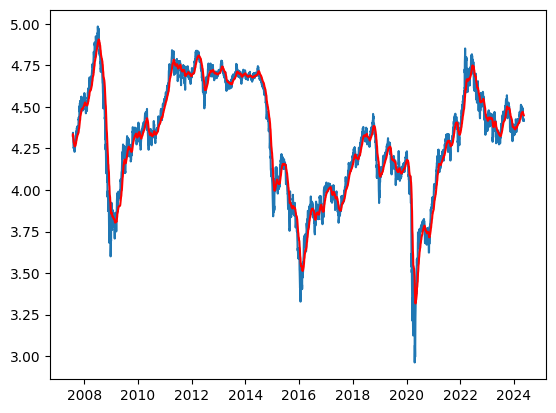

In [ ]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

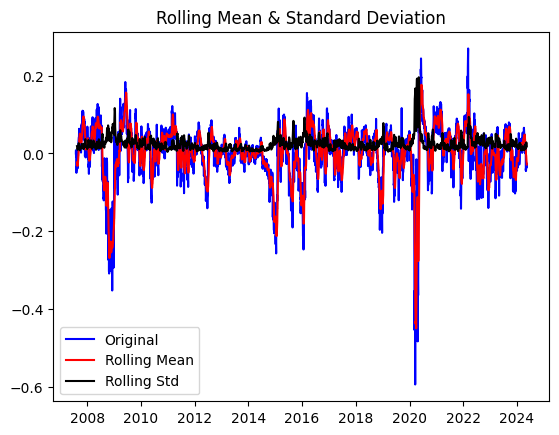

Results of Dickey Fuller Test:
Test Statistic                -7.708662e+00
p-value                        1.281227e-11
#Lags Used                     3.000000e+01
Number of Observations Used    4.138000e+03
Critical Value (1%)           -3.431931e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
# Subtraindo o dataset em escala logar√≠tma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3¬∫ teste : Diferencia√ß√£o



---



**Objetivo:** Remover a tend√™ncia e tornar a s√©rie mais estacion√°ria.

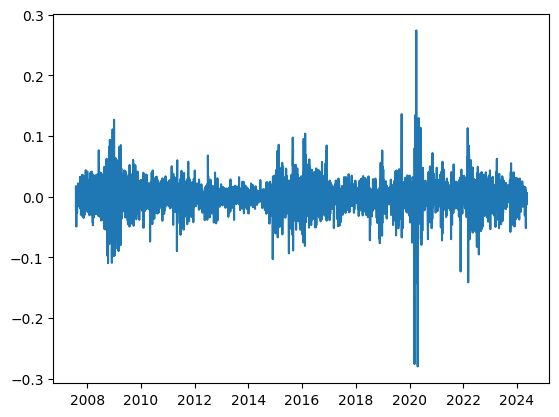

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferen√ßa entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

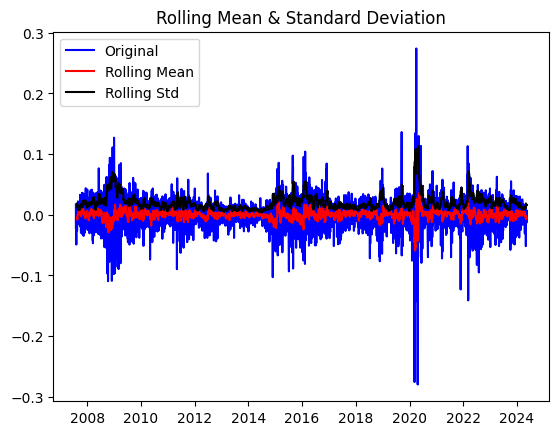

Results of Dickey Fuller Test:
Test Statistic                -9.546808e+00
p-value                        2.635887e-16
#Lags Used                     2.900000e+01
Number of Observations Used    4.138000e+03
Critical Value (1%)           -3.431931e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Teste de correla√ß√£o parcial

Como definimos numa primeira tentativa o par√¢metro **P (lags: valores auto correlacionados)** e o par√¢metro **Q (tamanho de uma janela)** do ARIMA?

Vamos fazer isso com os **gr√°fico de ACF** (para ‚Äòq‚Äô) e o **gr√°fico de PACF** (para ‚Äòp‚Äô). Vamos selecionar como teste a base de dados da **diferencia√ß√£o**.

Vamos encontrar em **qual ponto cada gr√°fico passa em zero e este ponto ser√° o valor de P e Q inicial** (talvez em alguns casos pequenas altera√ß√µes nos par√¢metros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags √© o n√∫mero de amostras):

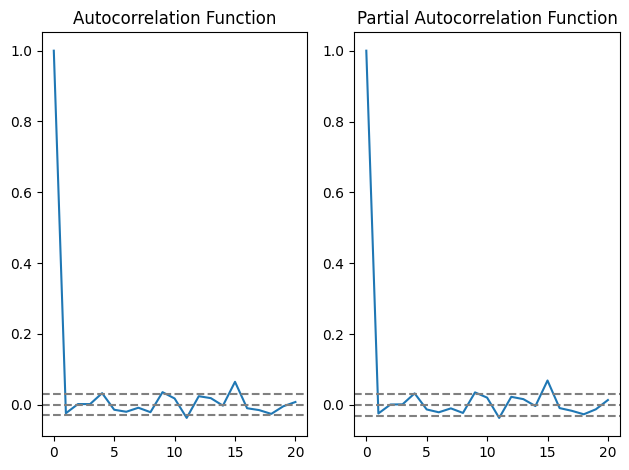

In [ ]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

Plotting AR model


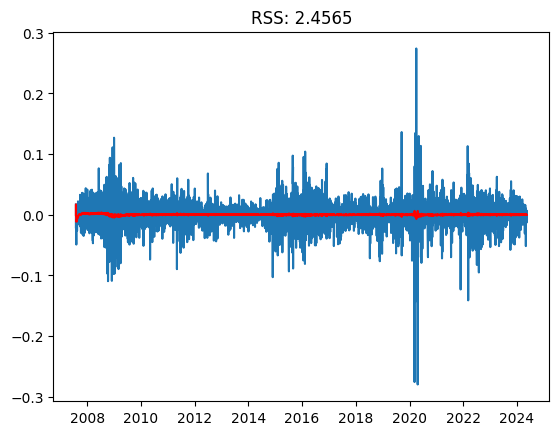

In [ ]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

**Validando o modelo com MAPE  (Mean Absolute Percentage Error)**

In [ ]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previs√µes
predictions = results_AR.fittedvalues

# Ajuste os √≠ndices para garantir correspond√™ncia
predictions.index = datasetLogDiffShifting.index

# Inverta a diferencia√ß√£o
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferencia√ß√£o.
# np.cumsum(predictions) √© usado para calcular a soma cumulativa das previs√µes.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 469.24%


# Testando o modelo com prophet üîÆ


In [ ]:
symbol = 'BZ=F'

start_date = '1987-05-20'
end_date = '2024-05-20'

# Use a fun√ß√£o download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a convers√£o da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()

df_copy = df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Separando em Treino e Teste

train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (3335, 4)
testing data size : (834, 4)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/2mzu5yfr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/1oyb_2bm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53248', 'data', 'file=/tmp/tmpfxfm4_c0/2mzu5yfr.json', 'init=/tmp/tmpfxfm4_c0/1oyb_2bm.json', 'output', 'file=/tmp/tmpfxfm4_c0/prophet_model6sz2x9x1/prophet_model-20240515030140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:01:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2007-07-31  76.966924   77.942162  106.672815    76.966924    76.966924   
1 2007-08-01  77.005027   77.425342  106.517516    77.005027    77.005027   
2 2007-08-03  77.081235   77.960515  105.816883    77.081235    77.081235   
3 2007-08-06  77.195547   76.631020  105.347874    77.195547    77.195547   
4 2007-08-07  77.233651   77.173282  105.041328    77.233651    77.233651   

   additive_terms  additive_terms_lower  additive_terms_upper      daily  ...  \
0       15.233573             15.233573             15.233573  12.016775  ...   
1       15.189702             15.189702             15.189702  12.016775  ...   
2       14.637910             14.637910             14.637910  12.016775  ...   
3       13.853052             13.853052             13.853052  12.016775  ...   
4       14.330215             14.330215             14.330215  12.016775  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0  0.720371      0.720371      0.720371  2.496428      2.496428      2.496428   
1  0.783225      0.783225      0.783225  2.389703      2.389703      2.389703   
2  0.471453      0.471453      0.471453  2.149682      2.149682      2.149682   
3  0.098166      0.098166      0.098166  1.738112      1.738112      1.738112   
4  0.720371      0.720371      0.720371  1.593070      1.593070      1.593070   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  92.200496  
1                         0.0  92.194730  
2                         0.0  91.719145  
3                         0.0  91.048599  
4                         0.0  91.563866  

[5 rows x 22 columns]

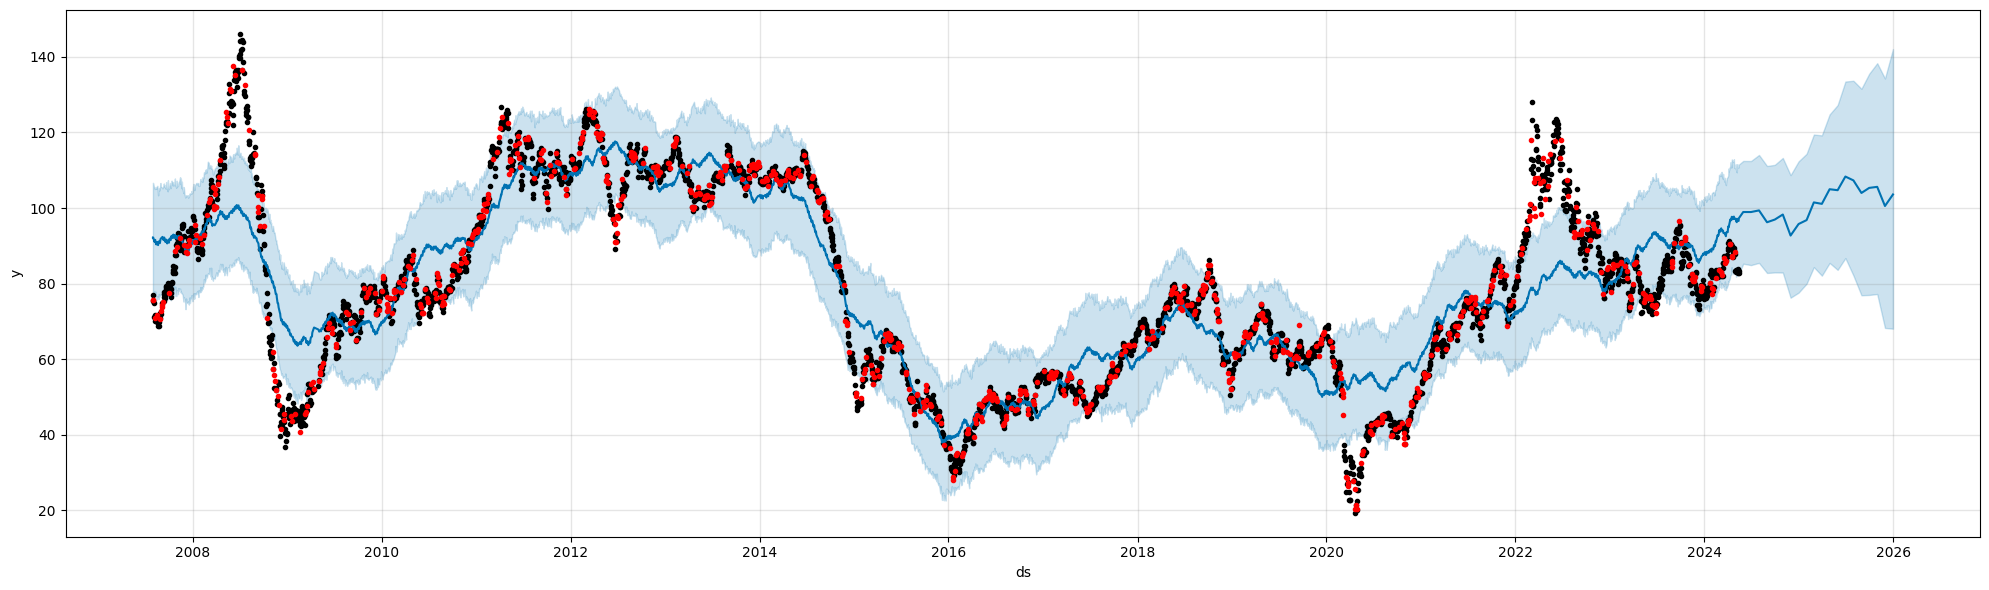

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

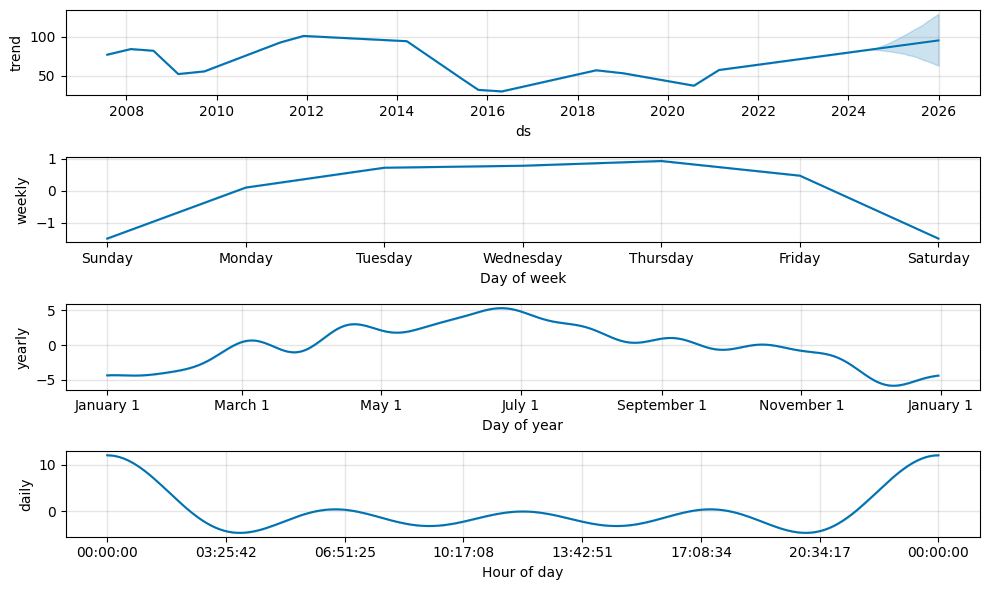

In [ ]:
modelo.plot_components(previsao, figsize=(10,6));

In [ ]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previs√µes e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 11.91%


In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 28 forecasts with cutoffs between 2010-01-23 00:00:00 and 2023-05-15 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/tp9azh4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/63_bdj8w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10822', 'data', 'file=/tmp/tmpfxfm4_c0/tp9azh4d.json', 'init=/tmp/tmpfxfm4_c0/63_bdj8w.json', 'output', 'file=/tmp/tmpfxfm4_c0/prophet_modeliblbf6c6/prophet_model-20240515030146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:01:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:01:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/_1o3px4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/g1jtznx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2010-01-27  79.712926   74.866874   84.004619  72.239998 2010-01-23
1 2010-01-28  80.238943   75.595160   84.312274  72.129997 2010-01-23
2 2010-01-29  80.234046   75.726740   84.909043  71.459999 2010-01-23
3 2010-02-01  80.933686   76.440926   85.519399  73.110001 2010-01-23
4 2010-02-03  81.155616   76.535229   85.650392  75.919998 2010-01-23

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

horizon          mse       rmse        mae      mape     mdape     smape  \
0    37 days   284.662273  16.871937  13.290470  0.203448  0.176248  0.202932   
1    38 days   287.625853  16.959536  13.377609  0.203998  0.177076  0.203832   
2    39 days   286.222755  16.918119  13.324994  0.202698  0.176248  0.202378   
3    40 days   286.997366  16.940997  13.367183  0.202754  0.175185  0.202439   
4    41 days   287.620296  16.959372  13.435516  0.203295  0.176248  0.203354   
..       ...          ...        ...        ...       ...       ...       ...   
324 361 days  1444.755719  38.009942  32.386143  0.500448  0.443623  0.538645   
325 362 days  1448.448189  38.058484  32.439939  0.503075  0.444822  0.540376   
326 363 days  1459.738550  38.206525  32.554129  0.505797  0.444822  0.542589   
327 364 days  1453.394506  38.123412  32.374673  0.501139  0.444822  0.541760   
328 365 days  1477.150822  38.433720  32.661044  0.505823  0.471450  0.543730   

     coverage  
0    0.381742  
1    0.377091  
2    0.378215  
3    0.374887  
4    0.366441  
..        ...  
324  0.542986  
325  0.546306  
326  0.549411  
327  0.553273  
328  0.546787  

[329 rows x 8 columns]

In [ ]:
### Aplicando o algoritmo LSTM para prever

df = df_brent
df['Date'] = pd.to_datetime(df['Date']) #realizando a convers√£o da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

Date      Close
0 2007-07-30  75.739998
1 2007-07-31  77.050003
2 2007-08-01  75.349998
3 2007-08-02  75.760002
4 2007-08-03  74.750000

In [ ]:
df.tail()

Date      Close
4164 2024-05-08  83.580002
4165 2024-05-09  83.879997
4166 2024-05-10  82.790001
4167 2024-05-13  83.360001
4168 2024-05-14  82.849998

In [ ]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [ ]:
#Normalizando os dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
#Separando em treino e teste

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

3335
834


In [ ]:
# Gerar sequ√™ncias temporais para treinamento e teste em um modelo de aprendizado de m√°quina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
167/167 [==============================] - 3s 8ms/step - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 2/20
167/167 [==============================] - 1s 8ms/step - loss: 9.7753e-04 - mean_squared_error: 9.7753e-04
Epoch 3/20
167/167 [==============================] - 1s 8ms/step - loss: 8.3259e-04 - mean_squared_error: 8.3259e-04
Epoch 4/20
167/167 [==============================] - 1s 8ms/step - loss: 6.8656e-04 - mean_squared_error: 6.8656e-04
Epoch 5/20
167/167 [==============================] - 2s 12ms/step - loss: 7.5312e-04 - mean_squared_error: 7.5312e-04
Epoch 6/20
167/167 [==============================] - 1s 9ms/step - loss: 6.4418e-04 - mean_squared_error: 6.4418e-04
Epoch 7/20
167/167 [==============================] - 1s 8ms/step - loss: 5.9525e-04 - mean_squared_error: 5.9525e-04
Epoch 8/20
167/167 [==============================] - 1s 8ms/step - loss: 5.3516e-04 - mean_squared_error: 5.3516e-04
Epoch 9/20
167/167 [==============================] - 1s 8ms/st

In [ ]:
symbol = 'BZ=F'

start_date = '1987-05-20' #data mais antiga do valor do IPEA (url providenciada no challenge)
end_date = '2024-05-20' #data escolhida para o final dos dados

# Use a fun√ß√£o download para obter os dados
dados_brent = yf.download(symbol, start=start_date, end=end_date)


# Pr√©-processamento dos dados para o modelo Prophet
dados_prophet = dados_brent.rename(columns={'Data': 'ds', '√öltimo': 'y'})

# Dividir os dados em conjuntos de treinamento e teste para o Prophet
tamanho_treino = int(len(dados_prophet) * 0.8)
dados_treino_prophet = dados_prophet[:tamanho_treino]
dados_teste_prophet = dados_prophet[tamanho_treino:]


[*********************100%%**********************]  1 of 1 completed


In [ ]:
dados_prophet

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...               ...        ...        ...        ...        ...     ...
2024-05-08  83.040001  83.820000  81.720001  83.580002  83.580002   35419
2024-05-09  83.779999  84.330002  83.459999  83.879997  83.879997   25231
2024-05-10  84.209999  84.519997  82.709999  82.790001  82.790001   25062
2024-05-13  82.699997  83.830002  82.260002  83.360001  83.360001   29242
2024-05-14  82.769997  82.910004  82.650002  82.849998  82.849998     401

[4169 rows x 6 columns]

In [ ]:
dados_brent

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...               ...        ...        ...        ...        ...     ...
2024-05-08  83.040001  83.820000  81.720001  83.580002  83.580002   35419
2024-05-09  83.779999  84.330002  83.459999  83.879997  83.879997   25231
2024-05-10  84.209999  84.519997  82.709999  82.790001  82.790001   25062
2024-05-13  82.699997  83.830002  82.260002  83.360001  83.360001   29242
2024-05-14  82.769997  82.910004  82.650002  82.849998  82.849998     401

[4169 rows x 6 columns]

In [ ]:
dados_treino_prophet.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387

In [ ]:
df.head()

Date      Close
0 2007-07-30  75.739998
1 2007-07-31  77.050003
2 2007-08-01  75.349998
3 2007-08-02  75.760002
4 2007-08-03  74.750000

In [ ]:
dados_treino_prophet

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...               ...        ...        ...        ...        ...     ...
2021-01-13  56.730000  57.419998  55.779999  56.060001  56.060001   32953
2021-01-14  55.939999  56.540001  55.240002  56.419998  56.419998   33446
2021-01-15  56.430000  56.639999  54.650002  55.099998  55.099998   30604
2021-01-19  54.740002  56.080002  54.500000  55.900002  55.900002   36910
2021-01-20  55.900002  56.619999  55.650002  56.080002  56.080002   33793

[3335 rows x 6 columns]

In [ ]:
dados_treino_prophet.reset_index(inplace=True)

In [ ]:
dados_treino_prophet

Date       Open       High        Low      Close  Adj Close  Volume
0    2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
1    2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2    2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
3    2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
4    2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...         ...        ...        ...        ...        ...        ...     ...
3330 2021-01-13  56.730000  57.419998  55.779999  56.060001  56.060001   32953
3331 2021-01-14  55.939999  56.540001  55.240002  56.419998  56.419998   33446
3332 2021-01-15  56.430000  56.639999  54.650002  55.099998  55.099998   30604
3333 2021-01-19  54.740002  56.080002  54.500000  55.900002  55.900002   36910
3334 2021-01-20  55.900002  56.619999  55.650002  56.080002  56.080002   33793

[3335 rows x 7 columns]

In [ ]:
dados_treino_prophet = dados_treino_prophet.rename(columns={'Date': 'ds'})
dados_treino_prophet = dados_treino_prophet.rename(columns={'Close': 'y'})

In [ ]:
dados_treino_prophet

ds       Open       High        Low          y  Adj Close  Volume
0    2007-07-30  75.849998  76.529999  75.440002  75.739998  75.739998    2575
1    2007-07-31  75.699997  77.169998  75.669998  77.050003  77.050003    3513
2    2007-08-01  77.000000  77.059998  74.860001  75.349998  75.349998    3930
3    2007-08-02  75.220001  76.209999  74.269997  75.760002  75.760002    6180
4    2007-08-03  75.389999  76.000000  74.529999  74.750000  74.750000    4387
...         ...        ...        ...        ...        ...        ...     ...
3330 2021-01-13  56.730000  57.419998  55.779999  56.060001  56.060001   32953
3331 2021-01-14  55.939999  56.540001  55.240002  56.419998  56.419998   33446
3332 2021-01-15  56.430000  56.639999  54.650002  55.099998  55.099998   30604
3333 2021-01-19  54.740002  56.080002  54.500000  55.900002  55.900002   36910
3334 2021-01-20  55.900002  56.619999  55.650002  56.080002  56.080002   33793

[3335 rows x 7 columns]

In [ ]:


# Criar e treinar o modelo Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(dados_treino_prophet)

# Realizar previs√µes com o modelo Prophet
datas_futuras_prophet = modelo_prophet.make_future_dataframe(periods=len(dados_teste_prophet), freq='D')
previsoes_prophet = modelo_prophet.predict(datas_futuras_prophet)

# Pr√©-processamento dos dados para o modelo LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
dados_lstm = df[['Close']]
dados_lstm_scaled = scaler.fit_transform(dados_lstm)

# Criar conjunto de treinamento para LSTM
passos = 60
x_lstm, y_lstm = [], []
for i in range(len(dados_lstm_scaled)-passos-1):
    x_lstm.append(dados_lstm_scaled[i:(i+passos), 0])
    y_lstm.append(dados_lstm_scaled[i + passos, 0])
x_lstm, y_lstm = np.array(x_lstm), np.array(y_lstm)
x_lstm = np.reshape(x_lstm, (x_lstm.shape[0], x_lstm.shape[1], 1))

# Criar modelo LSTM
modelo_lstm = Sequential()
modelo_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_lstm.shape[1], 1)))
modelo_lstm.add(LSTM(units=50))
modelo_lstm.add(Dense(units=1))
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo LSTM
modelo_lstm.fit(x_lstm, y_lstm, epochs=1, batch_size=1)

# Prever o fechamento para o dia xx/01/2024 usando ambos os modelos
data_previsao = pd.to_datetime('2024-05-04')
data_prophet = pd.DataFrame({'ds': [data_previsao]})
data_lstm = dados_lstm_scaled[-passos:].reshape(1, -1, 1)

# Previs√£o com o modelo Prophet
previsao_prophet = modelo_prophet.predict(data_prophet)

# Previs√£o com o modelo LSTM
previsao_lstm_scaled = modelo_lstm.predict(data_lstm)
previsao_lstm = scaler.inverse_transform(previsao_lstm_scaled)

# Imprimir as previs√µes
print(f'Previs√£o de fechamento para 04/05/2024 (Prophet): {previsao_prophet["yhat"].values[0]:.2f}')
print(f'Previs√£o de fechamento para 04/05/2024 (LSTM): {previsao_lstm[0, 0]:.2f}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/86voynxw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/pggebowl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46805', 'data', 'file=/tmp/tmpfxfm4_c0/86voynxw.json', 'init=/tmp/tmpfxfm4_c0/pggebowl.json', 'output', 'file=/tmp/tmpfxfm4_c0/prophet_model837vycnw/prophet_model-20240515030310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:03:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1/1 [==============================] - 1s 864ms/step
Previs√£o de fechamento para 04/05/2024 (Prophet): -2.28
Previs√£o de fechamento para 04/05/2024 (LSTM): 80.90


03/05/2024	83,60